In [1]:
from __future__ import division
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

churn_df = pd.read_csv('churn.csv')
col_names = churn_df.columns.tolist()

print("Column names:")
print(col_names)

to_show = col_names[:6] + col_names[-6:]

print("\nSample data:")
churn_df[to_show].head(6)

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


In [2]:
# target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

In [3]:
# Drop these columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

In [4]:
# Pull out features for future use
features = churn_feat_space.columns

X = churn_feat_space.as_matrix().astype(np.float)

In [5]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


In [6]:
from sklearn.model_selection import KFold

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(5,shuffle=True)
    y_pred = y.copy()

    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [7]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN

def accuracy(y_true,y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print("Support vector machines:")
print("%.3f" % accuracy(y, run_cv(X,y,SVC)))
print("Random forest:")
print("%.3f" % accuracy(y, run_cv(X,y,RF)))
print("K-nearest-neighbors:")
print("%.3f" % accuracy(y, run_cv(X,y,KNN)))

Support vector machines:
0.918
Random forest:
0.946
K-nearest-neighbors:
0.891


### Accuracy Metrics

In [8]:
from sklearn.metrics import confusion_matrix

y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
]


In [9]:
confusion_matrices

[('Support Vector Machines', array([[2817,   33],
         [ 234,  249]], dtype=int64)), ('Random Forest', array([[2823,   27],
         [ 160,  323]], dtype=int64)), ('K-Nearest-Neighbors',
  array([[2806,   44],
         [ 309,  174]], dtype=int64))]

In [10]:
import matplotlib.pyplot as plt

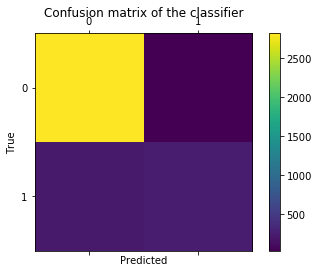

In [11]:
labels = ['0','1']
cm = confusion_matrix(y,run_cv(X,y,SVC))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [13]:
# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1779,0.027544
1,0.1,714,0.029412
2,0.2,263,0.053232
3,0.3,103,0.126214
4,0.8,84,0.928571
5,0.9,82,0.975610
6,0.7,76,0.881579
7,0.4,69,0.362319
8,1.0,64,1.000000
9,0.6,53,0.830189
